# Training a normalizing flow

In this notebook, we use the API in `flowMC` to train two different normalizing flow network to approximate a simple test distribution.
We train both a RealNVP flow, which is a simpler model from [Dinh 2016](https://arxiv.org/abs/1605.08803), and a more complex normalizing flow model, the rational quadratic spline model [Durkan 2019](https://arxiv.org/abs/1906.04032).

/mnt/home/wwong/Environment/GW/lib/python3.10/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))
Training NF, current loss: 1.177: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:20<00:00, 14.96it/s]


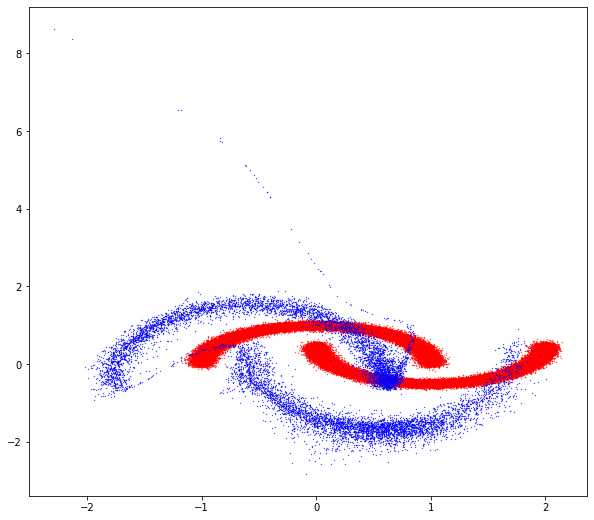

In [1]:
from flowMC.nfmodel.realNVP import RealNVP
from flowMC.nfmodel.rqSpline import RQSpline
import jax
import jax.numpy as jnp  # JAX NumPy
import jax.random as random  # JAX random

from flowMC.nfmodel.utils import *
from flax.training import train_state  # Useful dataclass to keep train state
import optax  # Optimizers
import flax


from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

"""
Training a masked RealNVP flow to fit the dual moons dataset.
"""

num_epochs = 300
batch_size = 10000
learning_rate = 0.001
momentum = 0.9
n_layers = 10
n_hidden = 100
dt = 1 / n_layers

data = jnp.array(make_moons(n_samples=100000, noise=0.05)[0])

key1, rng, init_rng = jax.random.split(jax.random.PRNGKey(0), 3)
model = RealNVP(10, 2, n_hidden, 1)

def create_train_state(rng, learning_rate, momentum):
    params = model.init(rng, jnp.ones((1, 2)))["params"]
    tx = optax.adam(learning_rate, momentum)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

state = create_train_state(init_rng, learning_rate, momentum)

variables = model.init(rng, jnp.ones((1, 2)))["variables"]
variables = variables.unfreeze()
variables["base_mean"] = jnp.mean(data, axis=0)
variables["base_cov"] = jnp.cov(data.T)
variables = flax.core.freeze(variables)

train_flow, train_epoch, train_step = make_training_loop(model)
rng, state, loss_values = train_flow(
    rng, state, variables, data, num_epochs, batch_size
)


rng_key_nf = jax.random.PRNGKey(124098)
rng_key, nf_samples = sample_nf(model, state.params, rng_key_nf, 10000, variables)
plt.figure(figsize=(10, 9))
plt.scatter(data[:, 0], data[:, 1], s=0.1, c="r", label="Data")
plt.scatter(nf_samples[:, 0], nf_samples[:, 1], s=0.1, c="b", label="NF")
plt.show()


Training NF, current loss: 1.206: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:24<00:00, 12.45it/s]


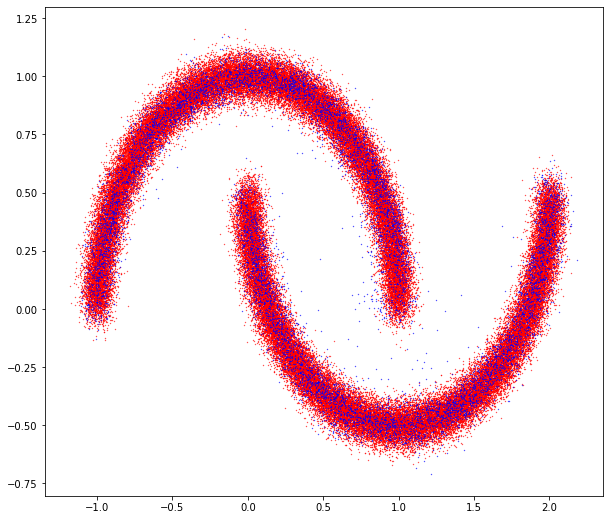

In [3]:
key1, rng, init_rng = jax.random.split(jax.random.PRNGKey(0), 3)
model = RQSpline(2, 8, [64, 64], 8)

def create_train_state(rng, learning_rate, momentum):
    params = model.init(rng, jnp.ones((1, 2)))["params"]
    tx = optax.adam(learning_rate, momentum)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

state = create_train_state(init_rng, learning_rate, momentum)

variables = model.init(rng, jnp.ones((1, 2)))["variables"]
variables = variables.unfreeze()
variables["base_mean"] = jnp.mean(data, axis=0)
variables["base_cov"] = jnp.cov(data.T)
variables = flax.core.freeze(variables)

train_flow, train_epoch, train_step = make_training_loop(model)
rng, state, loss_values = train_flow(
    rng, state, variables, data, num_epochs, batch_size
)


rng_key_nf = jax.random.PRNGKey(124098)
rng_key, nf_samples = sample_nf(model, state.params, rng_key_nf, 10000, variables)
plt.figure(figsize=(10, 9))
plt.scatter(data[:, 0], data[:, 1], s=0.1, c="r", label="Data")
plt.scatter(nf_samples[:,0], nf_samples[:,1], s=0.1, c="b", label="NF")
plt.show()
